This dataset is from R package "lefser":The ZellerG_2014 dataset contains microbiome count data for CRC patients and controls. It was for curatedMetagenomicData using the script in the package directory "data-raw". source https://pubmed.ncbi.nlm.nih.gov/25432777/

The result is from sbatch script: there are also ROC curve and SHAP plot (show the largest 20 features)

|          | number      | Random Forest   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 1585  | |0.487 (0.109) |0.472 (0.095)| 0.165 (0.173) |0.643 (0.064) |
| SelectMicro| 34  | |0.567 (0.093) |0.569 (0.093) | 0.320 (0.148) |0.682 (0.094)|
| Lasso_finetune    |19 | | 0.568 (0.080)|0.560 (0.081) |0.300 (0.127) |0.670 (0.060) |
| FS_Lasso_finetune |   20 |  | 0.512 (0.099)|0.509 (0.096)|0.218 (0.157)|0.664 (0.085) |



|          | number      | Random Forest   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 1585  | |0.482 (0.075) |0.475 (0.068)| 0.160 (0.103)|0.623 (0.041)|
| SelectMicro| 34  | |0.492 (0.121)| 0.491 (0.117)| 0.195 (0.178)| 0.634 (0.077)|
| Lasso_finetune    |19 | | 0.543 (0.091)|0.529 (0.090)| 0.250 (0.136)| 0.669 (0.081)|
| FS_Lasso_finetune |   20 |  | 0.477 (0.056)| 0.474 (0.051)|0.165 (0.081)|0.629 (0.048) |


|          | number      | SVM   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 1585  | |0.492 (0.082)| 0.497 (0.075)| 0.220 (0.115)| 0.654 (0.069)|
| SelectMicro| 34  | |0.497 (0.079)| 0.501 (0.064)| 0.242 (0.111)|0.665 (0.098)|
| Lasso_finetune    |19 | | 0.492 (0.076)|0.498 (0.078)|0.217 (0.132)| 0.665 (0.109)|
| FS_Lasso_finetune |   20 |  |0.492 (0.091)| 0.499 (0.087)| 0.216 (0.143)| 0.657 (0.093) |



|          | number      | NB   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 1585  | |0.336 (0.063)|0.315 (0.082)|0.099 (0.077)| 0.567 (0.039)|
| SelectMicro| 34  | |0.342 (0.085)|0.286 (0.116)|nan (nan)|0.679 (0.076)|
| Lasso_finetune    |19 | | 0.518 (0.029)| 0.456 (0.050)| 0.230 (0.080)| 0.686 (0.046)|
| FS_Lasso_finetune |   20 |  |0.352 (0.051)| 0.320 (0.071)| 0.182 (0.061)| 0.668 (0.080)|

In [1]:
import sys
sys.path.append('../../../Code')
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random

2025-04-09 17:55:39.471068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 17:55:39.475977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 17:55:40.175784: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 17:55:40.186729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744235740.204927 2168467 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744235740.21

In [2]:
data0 = pd.read_csv('../data/features_table_update.csv',index_col=0)

In [3]:
print(data0.index)
print(data0.shape)

Index(['CCIS00146684ST-4-0', 'CCIS00281083ST-3-0', 'CCIS02124300ST-4-0',
       'CCIS02379307ST-4-0', 'CCIS02856720ST-4-0', 'CCIS03473770ST-4-0',
       'CCIS03857607ST-4-0', 'CCIS05314658ST-4-0', 'CCIS06260551ST-3-0',
       'CCIS07277498ST-4-0',
       ...
       'CCMD88272491ST-21-0', 'CCMD90311071ST-21-0', 'CCMD93344354ST-21-0',
       'CCMD95433940ST-21-0', 'CCMD96553385ST-21-0', 'MMPU29365221ST',
       'MMPU68403337ST', 'MMPU72854103ST', 'MMPU84450604ST', 'MMPU99077057ST'],
      dtype='object', length=199)
(199, 1585)


In [4]:
cols_name = data0.columns

In [5]:
print(cols_name)

Index(['k__Bacteria', 'k__Viruses', 'k__Bacteria|p__Firmicutes',
       'k__Bacteria|p__Bacteroidetes', 'k__Bacteria|p__Actinobacteria',
       'k__Bacteria|p__Verrucomicrobia', 'k__Bacteria|p__Proteobacteria',
       'k__Viruses|p__Viruses_noname',
       'k__Bacteria|p__Candidatus_Saccharibacteria',
       'k__Bacteria|p__Firmicutes|c__Clostridia',
       ...
       'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Enhydrobacter',
       'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Enhydrobacter|s__Enhydrobacter_aerosaccus',
       'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Enhydrobacter|s__Enhydrobacter_aerosaccus|t__GCF_000175915',
       'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4',
       'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|

In [6]:
cols_name = np.array([x.split("|")[-1] for x in cols_name])

In [7]:
print(cols_name[:5])

['k__Bacteria' 'k__Viruses' 'p__Firmicutes' 'p__Bacteroidetes'
 'p__Actinobacteria']


In [8]:
data = pd.DataFrame(FS.relative_abundance(data0), columns=cols_name)

In [9]:
meta_2 = pd.read_csv('../data/meta_data.csv',index_col=0)
print(meta_2.shape)
print(meta_2.columns)

(199, 22)
Index(['subjectID', 'body_site', 'antibiotics_current_use', 'study_condition',
       'disease', 'disease_subtype', 'age', 'age_category', 'gender', 'BMI',
       'country', 'non_westernized', 'DNA_extraction_kit', 'number_reads',
       'number_bases', 'minimum_read_length', 'median_read_length', 'tnm',
       'ajcc', 'fobt', 'curator', 'NCBI_accession'],
      dtype='object')


In [10]:
print(meta_2['study_condition'].value_counts())
print(meta_2['disease'].value_counts())

study_condition
CRC        91
control    66
adenoma    42
Name: count, dtype: int64
disease
CRC        91
healthy    66
adenoma    42
Name: count, dtype: int64


CRC – Colorectal Cancer

Adenoma – Precancerous polyps (Benign growths in the colon that can develop into cancer if not treated.In studies: Considered an intermediate risk group—not cancer, but not healthy either.
Important for early detection models.)

In [11]:
# check the index of meta data and count table
data0.index.equals(meta_2.index)

True

In [12]:
y = meta_2['disease']

In [13]:
y.value_counts()

disease
CRC        91
healthy    66
adenoma    42
Name: count, dtype: int64

In [14]:
custom_order = ['healthy', 'adenoma', 'CRC']
custom_mapping = {category: i for i, category in enumerate(custom_order)}

target_variable = [custom_mapping[category] for category in y]
target_variable = np.array(target_variable)

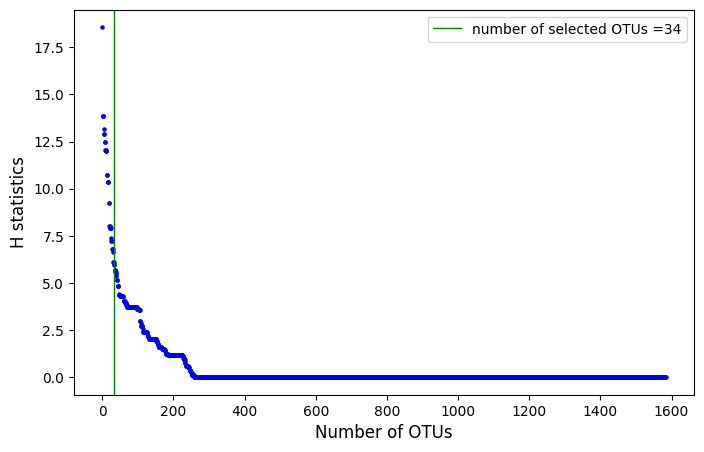

In [15]:
# 2. calculating H score for each OTU
selectedresult=FS.SelectMicro_fun(data,target_variable,p_cutoff = 0.05)

In [16]:
selectedOTU_index= selectedresult['selected_indices']
X_FS = selectedresult['selected_df']

In [17]:
dunn_results, summary = FS.calculate_dunn_tests_general(
    X_FS,
    target_variable,
    p_threshold=0.05
)

AttributeError: module 'FS' has no attribute 'calculate_dunn_tests_general'

In [ ]:
X_lasso_ft0,selectedOTU_index_Lasso  = RunML.LassoFS_CV(np.array(data),target_variable)
X_lasso_ft = pd.DataFrame(X_lasso_ft0, columns=cols_name[selectedOTU_index_Lasso])

X_FS_lasso_ft0,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(np.array(X_FS),target_variable)
selectedOTU_index_FS_lasso = selectedOTU_index[xlabel_FS_lasso_ft0]
X_FS_lasso_ft = pd.DataFrame(X_FS_lasso_ft0, columns=cols_name[selectedOTU_index_FS_lasso])

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft
              }

In [ ]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


In [ ]:
# Compute correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = X_FS.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5,cbar=True, xticklabels=False, yticklabels=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
print(f'The selected features of the SelectMicro dataset is ',X_FS.columns)
print(f'The selected features of the Lasso_finetune selected dataset is ',X_lasso_ft.columns)
print(f'The selected features of the FS_Lasso_finetune selected dataset is ',X_FS_lasso_ft.columns)
